In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
from __future__ import division, print_function

import matplotlib.pyplot as plt
import matplotlib.lines as mlines
#import seawater.gibbs as gsw

import netCDF4 as nc
import numpy as np
import scipy.io as sio
import pandas as pd
import pickle as pl
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'font.family': 'sans-serif',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
#matplotlib.rc('font',family='Times New Roman')
#matplotlib.rcParams['xtick.labelsize'] = 80.
#matplotlib.rcParams['ytick.labelsize'] = 80.
pylab.rcParams.update(params)

from salishsea_tools import nc_tools
from salishsea_tools import viz_tools
from salishsea_tools import  psu_tools

from matplotlib.pyplot import *
#from seabird.cnv import fCNV

from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.basemap import Basemap

%matplotlib inline

### Read the file.txt with pandas

In [3]:
data = pd.read_csv('/home/mgrenier/Documents/GEOTRACES_ARCTIC/GEOTRACES2015-Legs2b3b_ODV_forPaTh.txt',sep='\t')
#data
#data.head() # Displays the head of the table
#data.tail() # Displays the tail of the table

/home/mgrenier/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (0,10,24,26,27,28,29,30,31,32,33,34,35,37,38,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Rename and redefine variables

In [4]:
data.rename(columns={'yyyy-mm-ddThh:mm:ss.ss':'date',
                     'Longitude [degrees_east]':'lon','Latitude [degrees_north]':'lat',
                     'Bot. Depth [m]':'z_bottom','PRES_01 [decibars]':'P','Depth [metres]':'d',
                     'TE90_01 [degrees C]':'temp','PSAL_01 [psu]':'sal','SIGT_01 [kg/m**3]':'dens',
                     '231-Pa (fg/kg)':'Pa','230-Th (fg/kg)':'Th'}, inplace= True)

# Define the number of columns and rows to display
pd.options.display.max_columns = 64
pd.options.display.max_columns = 94

#data.head(n=2) # Displays the 2 first rows of the head of the table
#data.tail(n=2) # Displays the 2 first rows of the tail of the table

# Redefine the variables with a handy name
station = data.Station
date = data.date
lon = data.lon
lat = data.lat
P = data.P
d = data.d
t = data.temp
s = data.sal

print(t.values,s.values,d.values,'\n') # Returns Series as ndarray or ndarray-like depending on the dtype 
                           # Quotes around the numbers indicate that the type is an object, not a float

['6.327' '6.3266' '6.326' ..., nan nan nan] ['33.3184' '33.3171' '33.3176' ..., nan nan nan] [    6.94         7.932        8.924    ...,  2999.508565  3399.967178
          nan] 



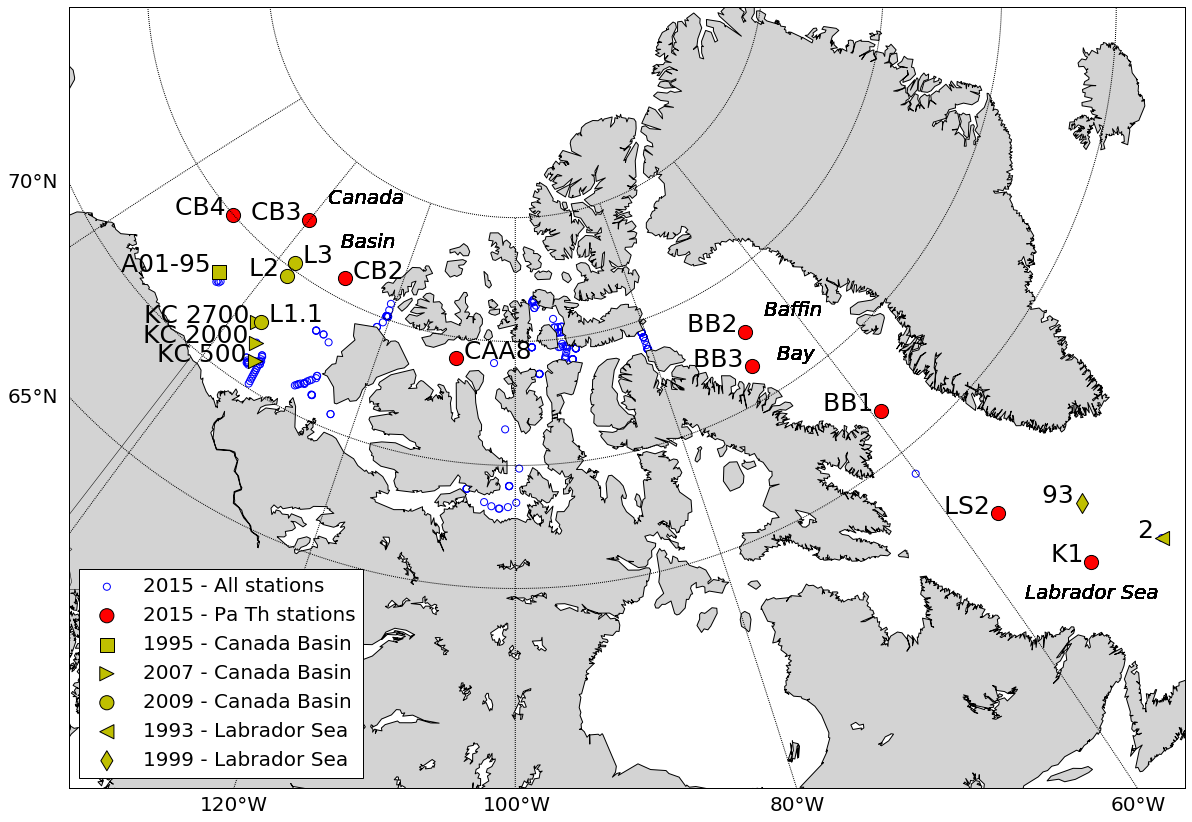

In [5]:
### Draw the map for the location of the stations

#m = Basemap(llcrnrlon=-170, llcrnrlat=50, urcrnrlon=-40, urcrnrlat=85,lon_0=-100, resolution='l',area_thresh=10,projection='merc')
fig,ax=plt.subplots(1,1,facecolor='w',figsize=(20,20))
x=100000
m = Basemap(llcrnrx=-20*x, llcrnry=-20*x, urcrnrx=+30*x, urcrnry=+15*x,lon_0=-100, lat_0=75,projection='ortho',resolution='l')
m.drawcoastlines()
m.drawcountries()
m.fillcontinents(color='lightgrey')
#m.bluemarble()

m.drawmeridians(np.arange(-160,-50,20), labels=[0,0,0,1],fontsize=20)
m.drawparallels(np.arange(65,85,5), labels=[1,0,0,0],fontsize=20)

lon1,lat1= m(lon[0],lat[0])
lon2,lat2=m(lon[14250],lat[14250])
#plt.plot(lon1,lat2,'o',color='red')
#plt.plot(lon2,lat2,'o',color='red')

for i in range(1,len(data.lon)-1,1):
    longi,lati= m(lon[i],lat[i])
    if lon[i] != lon[i-1]:
        plt.scatter(longi,lati, s=50, facecolors='none', edgecolors='b',label='2015 - All stations')


#print(lon)
#len(lon) 
#lon[0], lat[0],longi[0]

currentStation=[]
listStation=[]
previousStation=currentStation
leg=[]
for i in range(0,len(lon),1):
    longi,lati= m(lon[i],lat[i])
    if data.Th[i] >= 0: 
        # print(data.Station[i])
        currentStation=data.Station[i]
        if currentStation != previousStation: 
            previousStation=currentStation
            listStation.append(data.Station[i])
            for sta,name,M,F,H in zip(('K1','LS2','BB1','BB3','BB2','CB2','CB3','CB4','308/CAA8',
                                    'KC 500-2007','KC 2000-2007','KC 2700-2007','A01-95','L1.1-2009',
                                    'L2-2009','L3-2009','2','93'),
                                    ('K1','LS2','BB1','BB3','BB2',' CB2','CB3','CB4',' CAA8',
                                    'KC 500','KC 2000','KC 2700','A01-95',' L1.1','L2',' L3','2','93'),
                                    ('o','o','o','o','o','o','o','o','o','>','>','>','s','o','o','o','<','d'),
                                    ('red','red','red','red','red','red','red','red','red','y','y','y','y'
                                     ,'y','y','y','y','y'),
                                     ('right','right','right','right','right','left','right','right','left',
                                      'right','right','right','right','left','right','left','right','right')):
                if previousStation == sta:
                    plt.scatter(longi,lati,s=200,marker=M, facecolors=F, edgecolors='k',label=name)
                    ax.annotate(name+' ',xy=(longi,lati),horizontalalignment=H,fontsize=25)
                if previousStation == 'BB2':
                    ax.annotate('   Baffin \n\n     Bay',xy=(longi,lati),verticalalignment = 'center',
                                horizontalalignment='left',fontsize=20,fontstyle='italic')
                if previousStation == 'CB3':
                    ax.annotate('   Canada \n\n     Basin',xy=(longi,lati),verticalalignment = 'center',
                                horizontalalignment='left',fontsize=20,fontstyle='italic')
                if previousStation == 'K1':
                    ax.annotate('\nLabrador Sea',xy=(longi,lati),verticalalignment = 'top',
                                horizontalalignment='center',fontsize=20,fontstyle='italic')

handles, labels = ax.get_legend_handles_labels()

plt.legend((handles[0],handles[238],handles[243],handles[242],handles[246],handles[247],handles[248]),
           ('2015 - All stations','2015 - Pa Th stations','1995 - Canada Basin','2007 - Canada Basin',
            '2009 - Canada Basin','1993 - Labrador Sea','1999 - Labrador Sea'),scatterpoints=1,fontsize=20,
           loc='lower left');
savefig('Figures/AllStationsBlack-PaThStationsColor_Map.pdf',bbox_inches='tight')
savefig('Figures/AllStationsBlack-PaThStationsColor_Map.png',bbox_inches='tight')

''' pickle does not work...
with open('stationsMap.pkl', 'wb') as staMap:
    pl.dump(fig, staMap)
'''


plt.show()

#cmap = plt.get_cmap('jet')





In [6]:
len(handles)

249

In [7]:
labels[237],labels[248]

('CB3', '93')